In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms as T, models
import pandas as pd

import os
from timeit import default_timer as timer
from datetime import timedelta
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import random

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix as confusion_matrix_score,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    auc,
    precision_recall_curve
)

In [ ]:
from google.colab import drive, runtime

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Paths
DRIVE_DIR = '/content/drive/MyDrive'
PROJECT_ROOT_DIR = f'{DRIVE_DIR}/src'
DATA_DIR = f'{PROJECT_ROOT_DIR}/data'
LOG_DIR = f'{PROJECT_ROOT_DIR}/logs'
MODELS_DIR = f'{PROJECT_ROOT_DIR}/models'
PREDICTIONS_DIR = f'{PROJECT_ROOT_DIR}/predictions'
HYPERPARAMS_DIR = f'{PROJECT_ROOT_DIR}/hyperparams'
MODULES_DIR = f'{PROJECT_ROOT_DIR}/modules'
IMG_DIR = f'{DATA_DIR}/images'

IMG_SIZE = 224
FULL_COLUMN_LABELS = {
    "MEL": "Melanoma",
    "NV": "Melanocytic nevus",
    "BCC": "Basal cell carcinoma",
    "AK": "Actinic keratosis",
    "BKL": "Benign keratosis",
    "DF": "Dermatofibroma",
    "VASC": "Vascular lesion",
    "SCC": "Squamous cell carcinoma",
    "UNK": "None of the others"
  }

In [ ]:
def get_precision_recall_curve(ground_truth, predictions):
  precision, recall, _ = precision_recall_curve(ground_truth, predictions)
  plt.plot(recall, precision, lw=2)
  plt.xlabel('Revocação')
  plt.ylabel('Precisão')
  plt.title('Curva Precisão-Revocação')
  plt.show()

In [ ]:
def get_auc_precision_recall_curve(ground_truth, predictions):
    # Calcular precisão, revocação e limiares
    precision, recall, _ = precision_recall_curve(ground_truth, predictions)

    # Calcular a área sob a curva Precision-Recall
    pr_auc = auc(recall, precision)

    # Plotar a curva Precision-Recall
    plt.figure()
    plt.plot(recall, precision, lw=2, label=f'PR AUC = {pr_auc:.4f}')
    plt.xlabel('Revocação')
    plt.ylabel('Precisão')
    plt.title('Curva Precisão-Revocação AUC')
    plt.legend(loc='lower left')
    plt.grid()
    plt.show()

    return pr_auc  # Retornar o valor da PR AUC

In [ ]:
def get_roc_auc_curve(ground_truth, predictions):
  fpr, tpr, _ = roc_curve(ground_truth, predictions)
  roc_auc = auc(fpr, tpr)

  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('Taxa de Falsos Positivos')
  plt.ylabel('Taxa de Verdadeiros Positivos')
  plt.title('Curva ROC')
  plt.legend(loc="lower right")
  plt.show()

In [ ]:
test_labels_filename = f'{PREDICTIONS_DIR}/ensemble/2024-09-24_06-02-13_test_labels.npy'
ensemble_predictions_filename = f'{PREDICTIONS_DIR}/ensemble/2024-09-24_06-02-13_ensemble_predictions.npy'
estimators_predictions_filename = f'{PREDICTIONS_DIR}/ensemble/2024-09-24_06-02-13_estimators_predictions.npy'

In [ ]:
# Carregando os arquivos
test_labels = np.load(test_labels_filename)
ensemble_predictions = np.load(ensemble_predictions_filename)
estimators_predictions = np.load(estimators_predictions_filename)

In [ ]:
def get_metrics(ground_truth, predictions):
  accuracy = accuracy_score(ground_truth, predictions)
  precision = precision_score(ground_truth, predictions)
  recall = recall_score(ground_truth, predictions)
  f1score = f1_score(ground_truth, predictions)

  print(f'Acurácia: {accuracy:.6f} ({(accuracy * 100):.2f}%)')
  print(f'Precisão: {precision:.6f} ({(precision * 100):.2f}%)')
  print(f'Revocação: {recall:.6f} ({(recall * 100):.2f}%)')
  print(f'Pontuação F1: {f1score:.6f} ({(f1score * 100):.2f}%)')
  print('------------------------------------------')
  print('Relatório de Classificação:')
  print(classification_report(ground_truth, predictions, target_names=['non-melanoma', 'melanoma']))

  return accuracy, precision, recall, f1score

In [ ]:
def get_all_precision_recall_curve(ground_truth, predictions_model1, predictions_model2, predictions_model3):
    # Cores e labels dos modelos
    colors = ['blue', 'orange', 'green']
    labels = ['Comitê de RNCs', 'AlexNet', 'VGG-16']
    predictions = [predictions_model1, predictions_model2, predictions_model3]

    plt.figure(figsize=(8, 6))

    for i in range(3):
        precision, recall, _ = precision_recall_curve(ground_truth, predictions[i])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, lw=2, color=colors[i], label=f'{labels[i]} (PR AUC = {pr_auc:.2f})')

    # Customização do gráfico
    plt.xlabel('Revocação')
    plt.ylabel('Precisão')
    plt.title('Curva Precisão-Revocação')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

In [ ]:
def get_all_roc_auc_curve(ground_truth, predictions_model1, predictions_model2, predictions_model3):
    # Cores e labels dos modelos
    colors = ['blue', 'orange', 'green']
    labels = ['Comitê de RNCs', 'AlexNet', 'VGG-16']
    predictions = [predictions_model1, predictions_model2, predictions_model3]

    plt.figure(figsize=(8, 6))

    for i in range(3):
        fpr, tpr, _ = roc_curve(ground_truth, predictions[i])
        roc_auc = roc_auc_score(ground_truth, predictions[i])
        plt.plot(fpr, tpr, lw=2, color=colors[i], label=f'{labels[i]} (ROC AUC = {roc_auc:.2f})')

    # Linha de referência (linha diagonal para ROC)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)

    # Customização do gráfico
    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.title('Curva ROC AUC')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

## Comitê de RNCs

In [ ]:
print('Comitê de RNCs')
get_metrics(test_labels, ensemble_predictions)

Comitê de RNCs
Acurácia: 0.791111 (79.11%)
Precisão: 0.756863 (75.69%)
Revocação: 0.857778 (85.78%)
Pontuação F1: 0.804167 (80.42%)
------------------------------------------
Relatório de Classificação:
              precision    recall  f1-score   support

non-melanoma       0.84      0.72      0.78       675
    melanoma       0.76      0.86      0.80       675

    accuracy                           0.79      1350
   macro avg       0.80      0.79      0.79      1350
weighted avg       0.80      0.79      0.79      1350



(0.7911111111111111,
 0.7568627450980392,
 0.8577777777777778,
 0.8041666666666667)

Comitê de RNCs


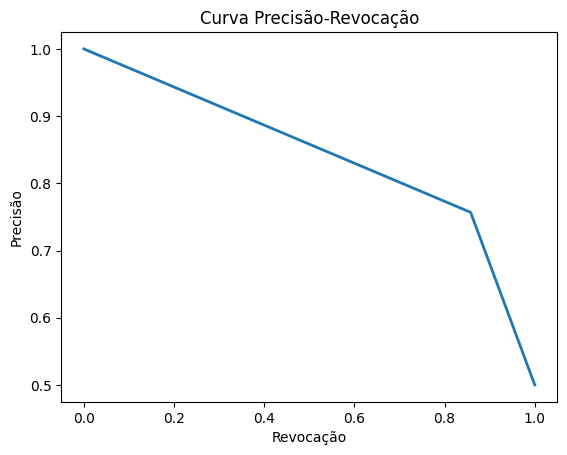

In [ ]:
print('Comitê de RNCs')
get_precision_recall_curve(test_labels, ensemble_predictions)

Comitê de RNCs


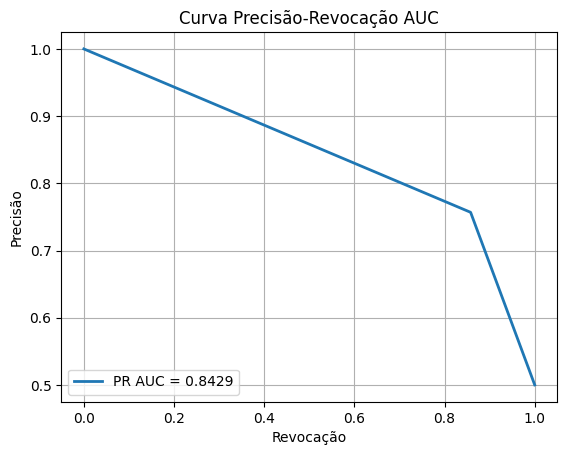

0.842875816993464

In [ ]:
print('Comitê de RNCs')
get_auc_precision_recall_curve(test_labels, ensemble_predictions)

Comitê de RNCs


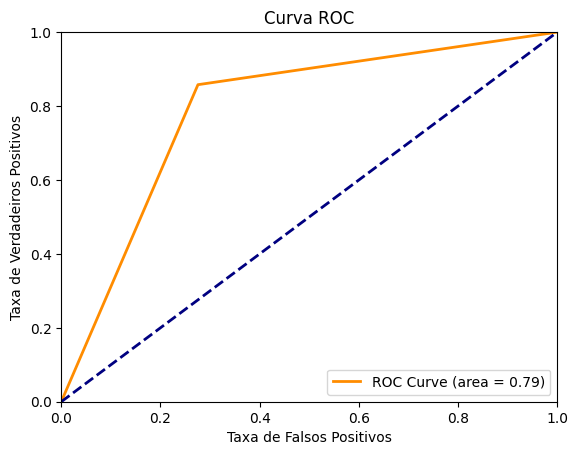

In [ ]:
print('Comitê de RNCs')
get_roc_auc_curve(test_labels, ensemble_predictions)

## AlexNet

In [ ]:
alexnet_predictions_filename = f'{PREDICTIONS_DIR}/transfer_learning/2024-09-23_14-23-57_alexnet_predictions.npy'

In [ ]:
alexnet_predictions = np.load(alexnet_predictions_filename)

In [ ]:
print('AlexNet')
get_metrics(test_labels, alexnet_predictions)

AlexNet
Acurácia: 0.760741 (76.07%)
Precisão: 0.756560 (75.66%)
Revocação: 0.768889 (76.89%)
Pontuação F1: 0.762675 (76.27%)
------------------------------------------
Relatório de Classificação:
              precision    recall  f1-score   support

non-melanoma       0.77      0.75      0.76       675
    melanoma       0.76      0.77      0.76       675

    accuracy                           0.76      1350
   macro avg       0.76      0.76      0.76      1350
weighted avg       0.76      0.76      0.76      1350



(0.7607407407407407,
 0.7565597667638484,
 0.7688888888888888,
 0.7626745040411462)

AlexNet


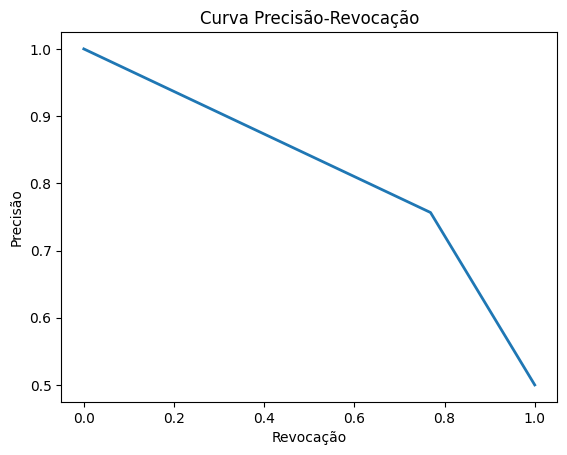

In [ ]:
print('AlexNet')
get_precision_recall_curve(test_labels, alexnet_predictions)

AlexNet


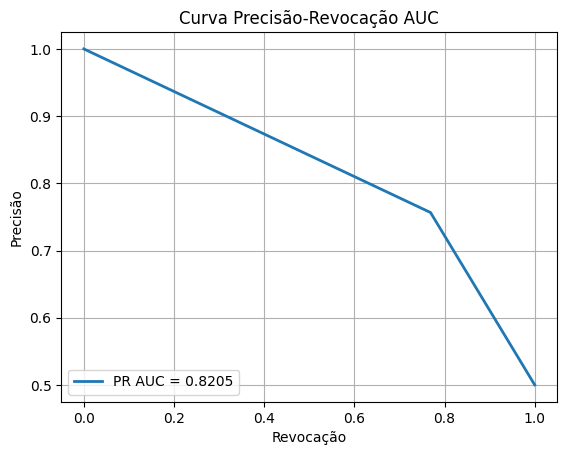

0.8205021056041464

In [ ]:
print('AlexNet')
get_auc_precision_recall_curve(test_labels, alexnet_predictions)

AlexNet


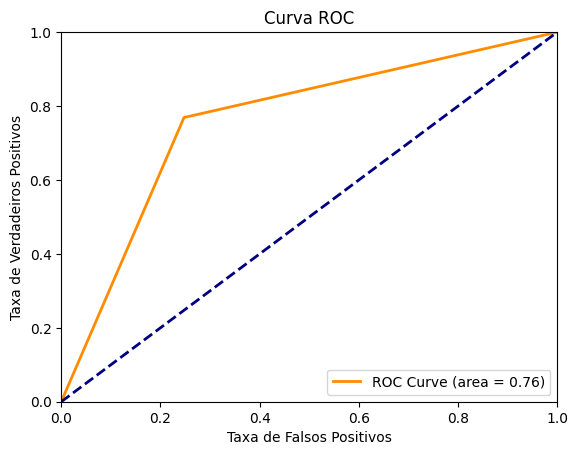

In [ ]:
print('AlexNet')
get_roc_auc_curve(test_labels, alexnet_predictions)

## VGG

In [ ]:
vgg16_predictions_filename = f'{PREDICTIONS_DIR}/transfer_learning/2024-09-23_15-21-44_vgg16_predictions.npy'

In [ ]:
vgg16_predictions = np.load(vgg16_predictions_filename)

In [ ]:
print('VGG-16')
get_metrics(test_labels, vgg16_predictions)

VGG-16
Acurácia: 0.703704 (70.37%)
Precisão: 0.689133 (68.91%)
Revocação: 0.742222 (74.22%)
Pontuação F1: 0.714693 (71.47%)
------------------------------------------
Relatório de Classificação:
              precision    recall  f1-score   support

non-melanoma       0.72      0.67      0.69       675
    melanoma       0.69      0.74      0.71       675

    accuracy                           0.70      1350
   macro avg       0.70      0.70      0.70      1350
weighted avg       0.70      0.70      0.70      1350



(0.7037037037037037,
 0.6891334250343879,
 0.7422222222222222,
 0.7146932952924394)

VGG-16


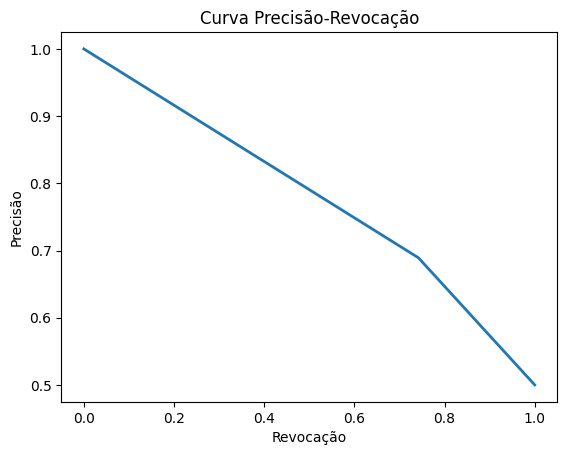

In [ ]:
print('VGG-16')
get_precision_recall_curve(test_labels, vgg16_predictions)

VGG-16


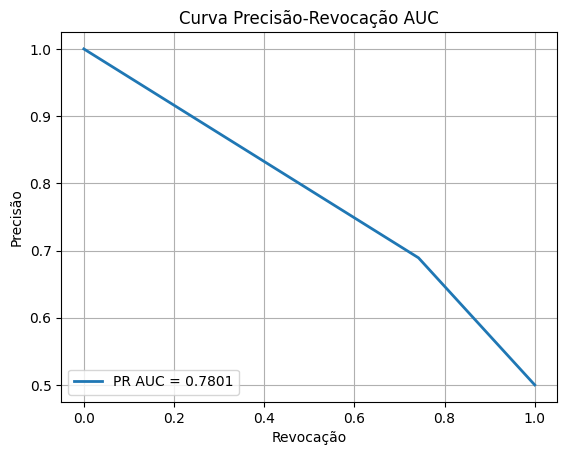

0.7801222680727495

In [ ]:
print('VGG-16')
get_auc_precision_recall_curve(test_labels, vgg16_predictions)

VGG-16


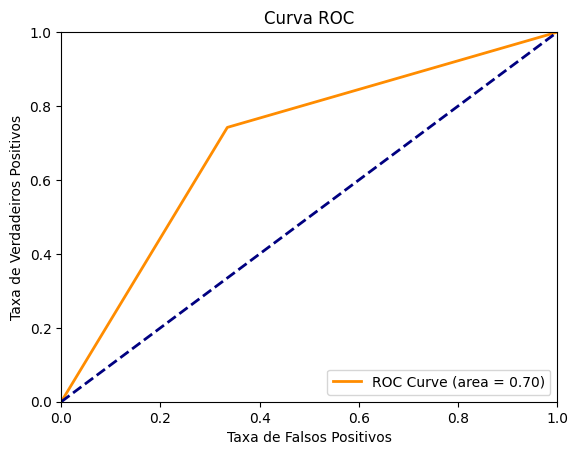

In [ ]:
print('VGG-16')
get_roc_auc_curve(test_labels, vgg16_predictions)

## Todos os modelos

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

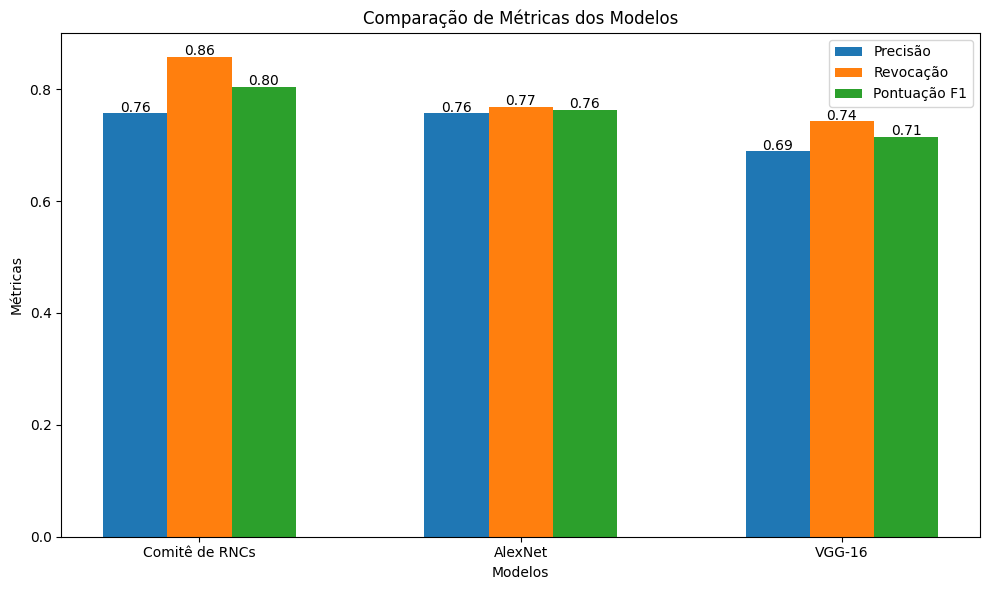

In [ ]:
# Dados
modelos = ['Comitê de RNCs', 'AlexNet', 'VGG-16']
acuracia = [0.791111, 0.760741, 0.703704]
precisao = [0.756863, 0.756560, 0.689133]
revocacao = [0.857778, 0.768889, 0.742222]
pontuacao_f1 = [0.804167, 0.762675, 0.714693]

# Gráfico de comparação das métricas
x = np.arange(len(modelos))  # posições dos modelos
largura = 0.2  # largura das barras

# Gráfico de comparação das métricas com título reduzido e legenda ajustada
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - largura, precisao, largura, label='Precisão')
bar2 = ax.bar(x, revocacao, largura, label='Revocação')
bar3 = ax.bar(x + largura, pontuacao_f1, largura, label='Pontuação F1')

# Adicionando rótulos e título
ax.set_xlabel('Modelos')
ax.set_ylabel('Métricas')
ax.set_title('Comparação de Métricas dos Modelos')
ax.set_xticks(x)
ax.set_xticklabels(modelos)

# Ajustando a posição da legenda no canto superior direito
ax.legend(loc='upper right')

# Adicionando valores nas barras sem sobreposição
for bars in (bar1, bar2, bar3):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, -1),  # Ajuste de distância para evitar sobreposição
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

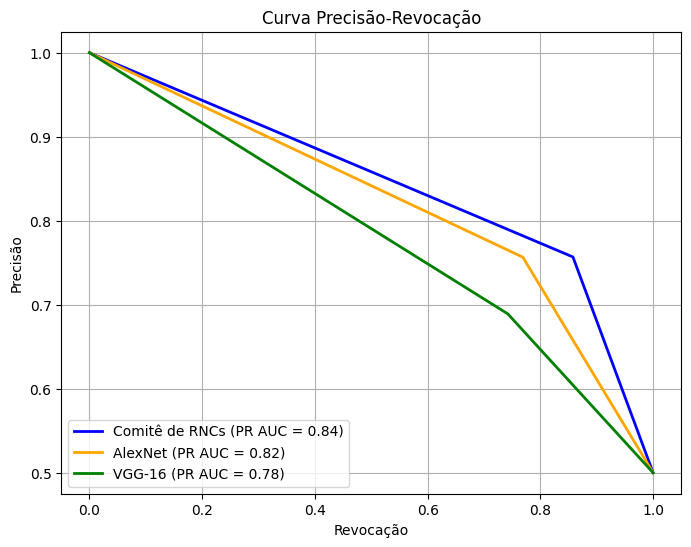

In [ ]:
get_all_precision_recall_curve(test_labels, ensemble_predictions, alexnet_predictions, vgg16_predictions)

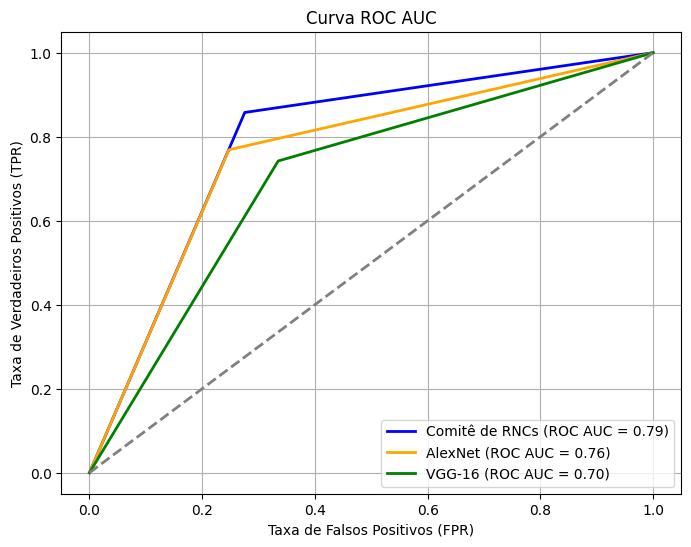

In [ ]:
get_all_roc_auc_curve(test_labels, ensemble_predictions, alexnet_predictions, vgg16_predictions)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dados
modelos = ['Comitê de RNCs', 'AlexNet', 'VGG-16']
precisao = [0.76, 0.76, 0.69]
revocacao = [0.86, 0.77, 0.74]
pontuacao_f1 = [0.80, 0.76, 0.71]

# Gráfico de comparação das métricas
x = np.arange(len(modelos))  # posições dos modelos
largura = 0.2  # largura das barras

# Gráfico de comparação das métricas com título reduzido e legenda ajustada
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - largura, precisao, largura, label='Precisão')
bar2 = ax.bar(x, revocacao, largura, label='Revocação')
bar3 = ax.bar(x + largura, pontuacao_f1, largura, label='Pontuação F1')

# Adicionando rótulos e título
ax.set_xlabel('Modelos')
ax.set_ylabel('Métricas')
ax.set_title('Comparação de Métricas dos Modelos para a classe Melanoma')
ax.set_xticks(x)
ax.set_xticklabels(modelos)

# Ajustando a posição da legenda no canto superior direito
ax.legend(loc='upper right')

# Adicionando valores nas barras sem sobreposição
for bars in (bar1, bar2, bar3):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, -1),  # Ajuste de distância para evitar sobreposição
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

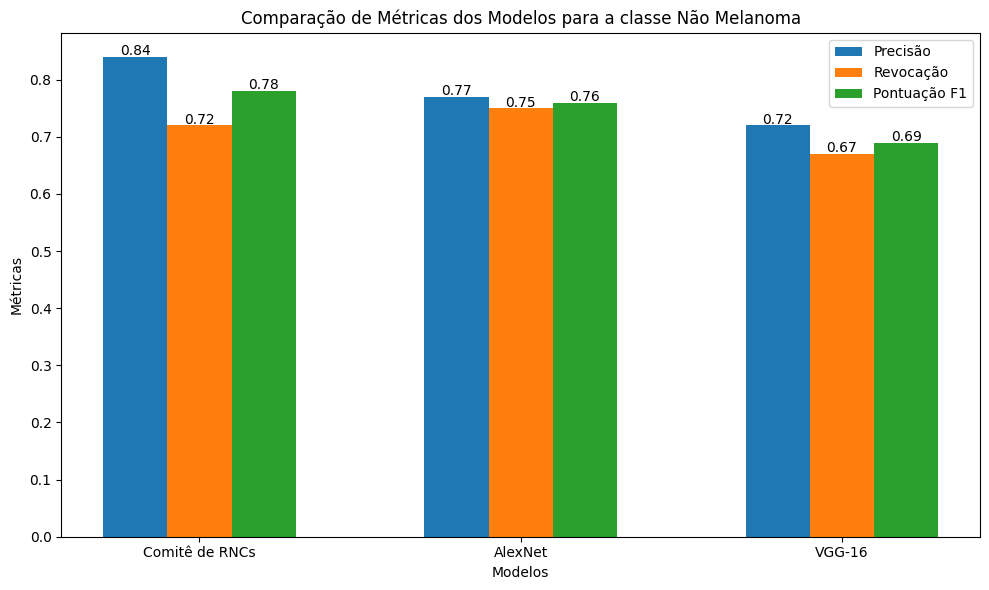

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dados
modelos = ['Comitê de RNCs', 'AlexNet', 'VGG-16']
precisao = [0.84, 0.77, 0.72]
revocacao = [0.72, 0.75, 0.67]
pontuacao_f1 = [0.78, 0.76, 0.69]

# Gráfico de comparação das métricas
x = np.arange(len(modelos))  # posições dos modelos
largura = 0.2  # largura das barras

# Gráfico de comparação das métricas com título reduzido e legenda ajustada
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - largura, precisao, largura, label='Precisão')
bar2 = ax.bar(x, revocacao, largura, label='Revocação')
bar3 = ax.bar(x + largura, pontuacao_f1, largura, label='Pontuação F1')

# Adicionando rótulos e título
ax.set_xlabel('Modelos')
ax.set_ylabel('Métricas')
ax.set_title('Comparação de Métricas dos Modelos para a classe Não Melanoma')
ax.set_xticks(x)
ax.set_xticklabels(modelos)

# Ajustando a posição da legenda no canto superior direito
ax.legend(loc='upper right')

# Adicionando valores nas barras sem sobreposição
for bars in (bar1, bar2, bar3):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, -1),  # Ajuste de distância para evitar sobreposição
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()